In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce
from scipy.signal import argrelextrema


In [2]:
plt.style.use('ggplot')

In [3]:
path = 'C:\\Work\Projects\\python\\flask\strategies\\igdata'

In [4]:
pairs_list = []
for filename in os.listdir(path):
    if filename.endswith('.csv'):
        pairs_list.append(filename.split('.')[0])
print(pairs_list)


['naturalgas_1H', 'naturalgas_4H', 'naturalgas_D']


In [5]:

df = {}
dd = {}

for pair in range(len(pairs_list)):
    t = str(pairs_list[pair].split('_')[1])
    df[pair] = pd.read_csv(path + '\\' + pairs_list[pair]+'.csv', header = 2)
    #df[pair].drop([4,5,6,7,8,9,10,11,12], axis=01)
    #df[pair] = df[pair].iloc[0,1,2,3,4,13]
    df[pair] = df[pair].iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13]]
    df[pair].columns = ['Date', 'Bid Open', 'Bid High', 'Bid Low', 'Bid Close',\
                                'Ask Open', 'Ask High', 'Ask Low', 'Ask Close',\
                                'Open', 'High', 'Low', 'Close', 'Volume']
    df[pair]['Open'] = df[pair]['Bid Open']
    df[pair]['High'] = df[pair]['Bid High']
    df[pair]['Low'] = df[pair]['Bid Low']
    df[pair]['Close'] = df[pair]['Bid Close']
    #df[pair]['Date'] = df[pair]['Date'].str.split(' ').str[0:2]
    #df[pair]['Date'] = df[pair]['Date'].str.join(' ')
    df[pair].set_index('Date', inplace = True)
    df[pair].index = pd.to_datetime(df[pair].index, format = '%Y.%m.%d %H:%M:%S.%f')
    df[pair]['Day'] = df[pair].index.dayofweek
    dmap = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    df[pair]['Day'] = df[pair]['Day'].map(dmap)
    df[pair]['min'] = ''
    df[pair]['max'] = ''
    dd[t] = df[pair]
    
for key in dd:
    print(f'Key: {key} - rows: {len(dd[key])}')


Key: 1H - rows: 5914
Key: 4H - rows: 1598
Key: D - rows: 939


In [6]:
def SMA(df, period):
    df[str(period) + '_sma'] = df['Close'].rolling(period).mean()
    return df[str(period) + '_sma']

def EMA(df, period):
    df[str(period) + '_ema'] = df['Close'].ewm(span = period,adjust=False).mean()
    return  df[str(period) + '_ema']

def PriceCrossover(df, price_col, indicator_col):
    conditions  = [ (df[indicator_col].shift(1) > df[price_col].shift(1)) & (df[indicator_col] < df[price_col]),\
                    (df[indicator_col].shift(1) < df[price_col].shift(1)) & (df[indicator_col] > df[price_col])]
    choices     = ['BreakUp','BreakDown']
    df[price_col +'_'+ indicator_col + '_crossover'] = np.select(conditions, choices, default=np.nan)
    df[price_col +'_'+ indicator_col + '_crossover_price'] = np.where(df[price_col +'_'+ indicator_col + '_crossover']==\
                                                                      'nan','nan',df[price_col])
    return  df

def Trend(df):
    conditions  = [(df['Close'] > df['100_sma']) & (df['100_sma'] > df['200_sma']),\
                    (df['Close'] < df['100_sma']) & (df['100_sma'] < df['200_sma'])]
    choices     = ['Up','Down']
    df['Trend'] = np.select(conditions, choices, default=np.nan)
    return  df['Trend']

def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

def CAGR(df, source_df):
    df = df.copy()
    n = len(source_df) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)

def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)


In [7]:
#Strategy parameters
account_size = 10000
slippage = 2
size = 1
ATR_SL = 0.5
spread = 2
plot_trades = False
pair = 'D'

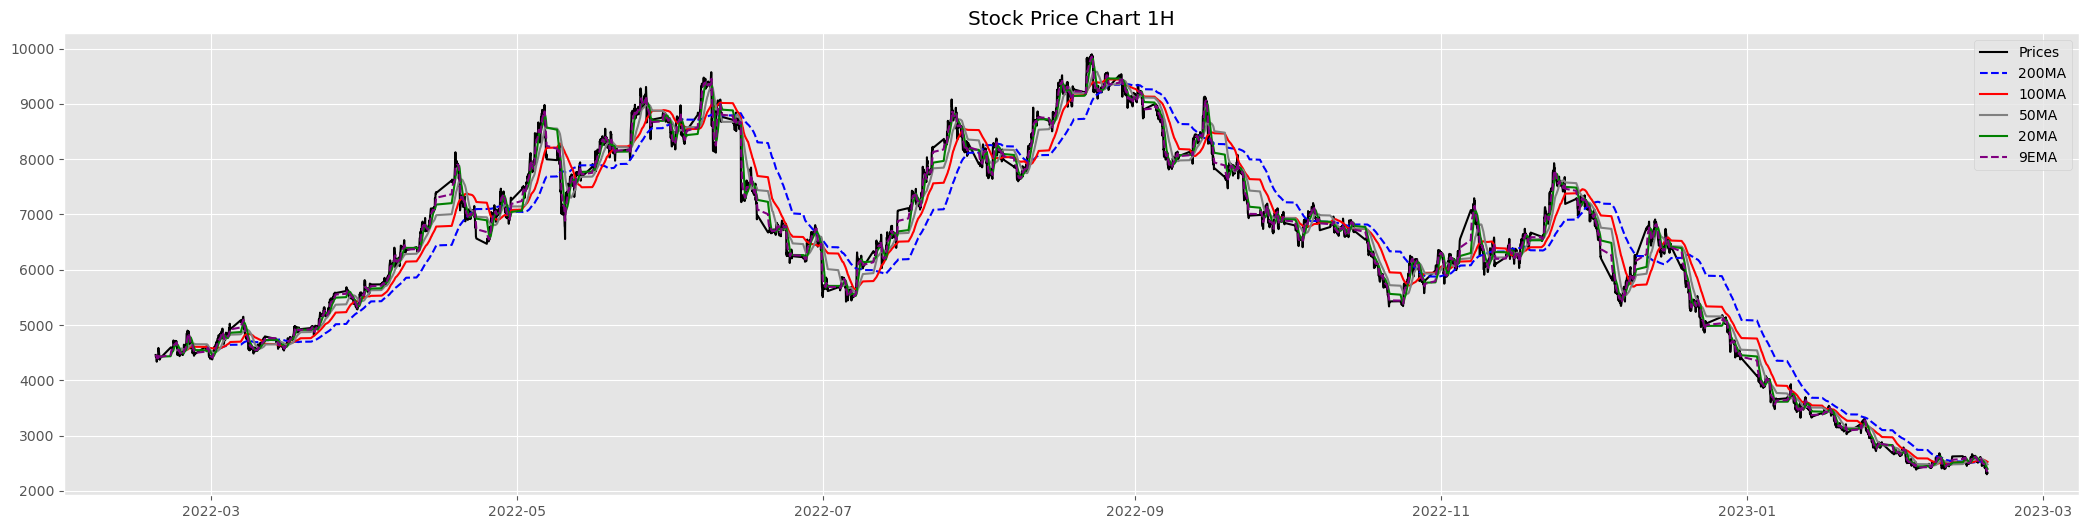

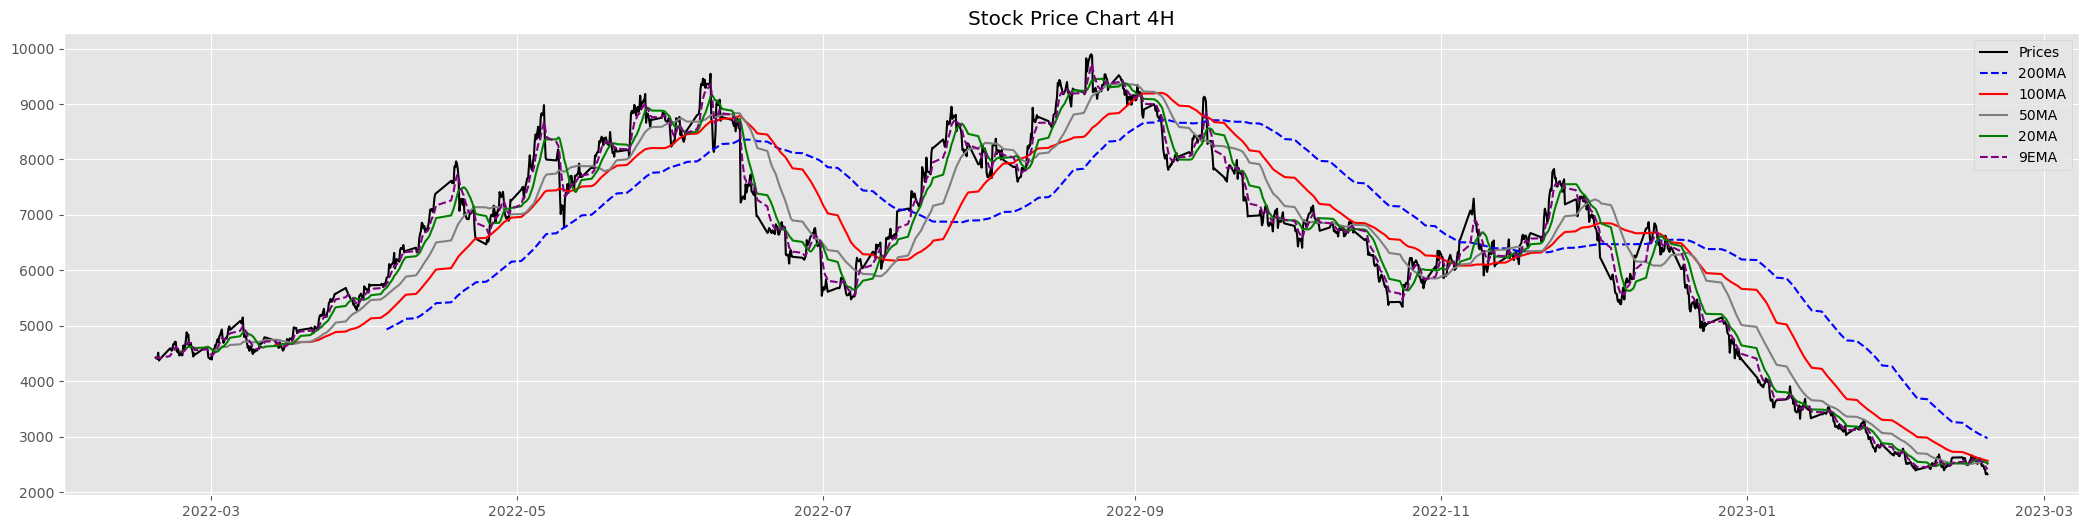

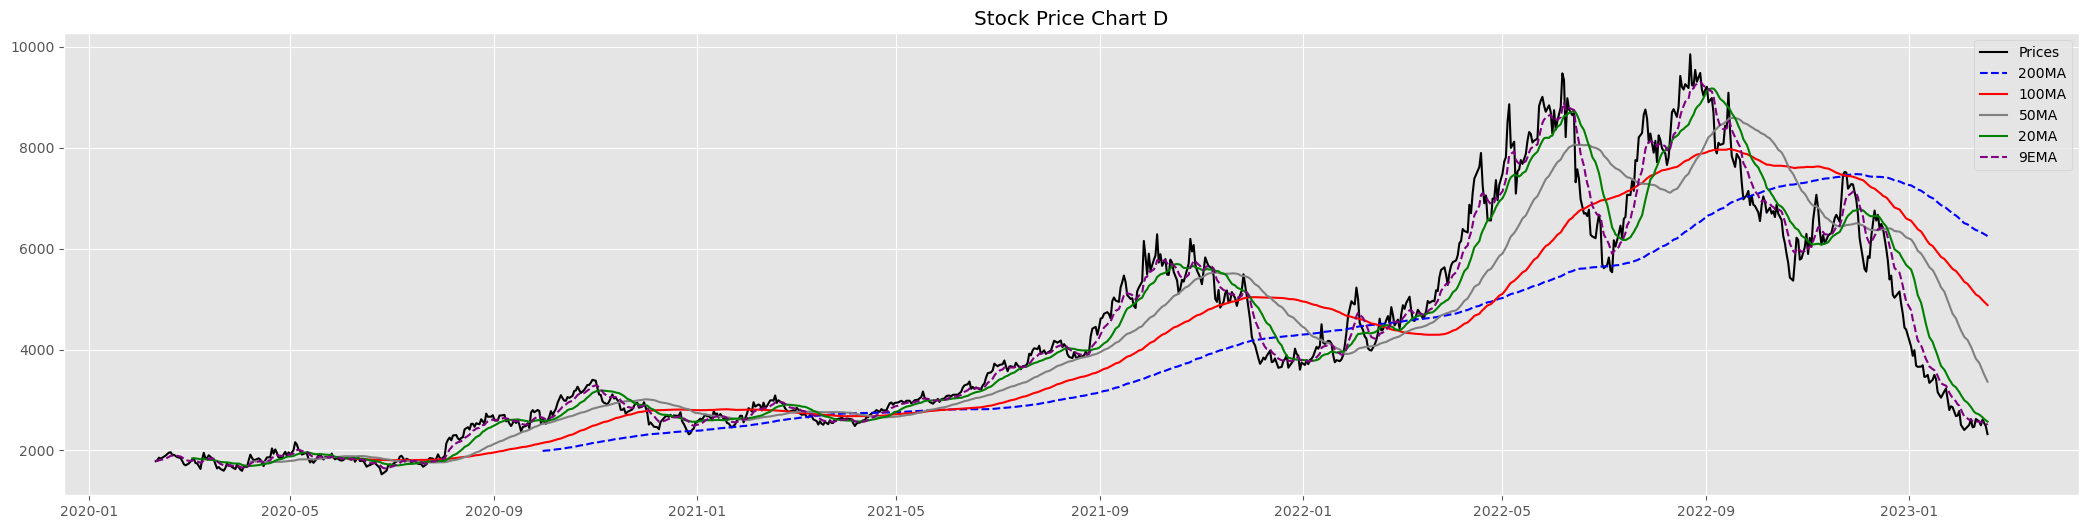

In [8]:
for res in dd:
    price = dd[res]['Close']
    #SMA(df[pair], 200).to_csv('200sma.csv')
    dd[res]['200_sma'] = SMA(dd[res], 200)
    dd[res]['100_sma'] = SMA(dd[res], 100)
    dd[res]['50_sma'] = SMA(dd[res], 50)
    dd[res]['20_sma'] = SMA(dd[res], 20)
    dd[res]['9_ema'] = EMA(dd[res], 9)
    dd[res]['Trend'] = Trend(dd[res])
    dd[res]['Close_9_ema_crossover'] = PriceCrossover(dd[res], 'Close','9_ema')['Close_9_ema_crossover']
    dd[res].to_csv(f'NG_{res}.csv')
    
    plt.figure(figsize = (26, 6))
    #plt.plot({'Open':df[pair]['Open'],'Close':df[pair]['Close'],'High':df[pair]['High'],'Low':df[pair]['Low']})
    #quotes = [df[pair]['Open'], df[pair]['Close'], df[pair]['High'], df[pair]['Low'], df[pair]['Close']]
    #ax = plt.gca()
    #h = matplotlib.finance.candlestick(ax, quotes)
    #plt.show()
    
    plt.title("Stock Price Chart " +  res)
    plt.plot(dd[res]['Close'], label='Prices',color = 'black')
    plt.plot(dd[res]['200_sma'], label='200MA',color = 'blue', linestyle='dashed',linewidth=1.5)
    plt.plot(dd[res]['100_sma'], label='100MA',color = 'red')
    plt.plot(dd[res]['50_sma'], label='50MA',color = 'grey')
    plt.plot(dd[res]['20_sma'], label='20MA',color = 'green')
    plt.plot(dd[res]['9_ema'], label='9EMA',color = 'purple', linestyle='dashed')
    #plt.scatter(dd[res].index, np.where(dd[res]['Close_9_ema_crossover']!=np.nan, dd[res]['Close_9_ema_crossover_price'] ,np.nan),  s = 20, color = 'green')
    #plt.scatter(dd[res].index, dd[res]['Close_9_ema_crossover_price'],  s = 20, color = 'green')
    plt.legend()
    #plt.figure()

    

In [9]:
def trade_plot(df, trade, exit_price, exit_date):
    plt.figure(figsize = (25, 8))
    plt.title(trade['signal'] + ' - With result: ' + str(round(trade['result'], 2)))
    plt.plot(df['Close'][(trade['date_of_trade'] - datetime.timedelta(days = 1000)): (trade['date_of_trade'] + datetime.timedelta(days = 30))], color = 'blue')
    plt.axhline(trade['TP'], color = 'green', ls = ':')
    plt.axhline(trade['SL'], color = 'red', ls = ':')
    plt.scatter(df.index, df['min'], color = 'red', s = 100)
    plt.scatter(df.index, df['max'], color = 'green', s = 100)
    plt.scatter(trade['date_of_trade'], trade['entry_price'], color = 'yellow', s = 200)
    plt.scatter(exit_date, exit_price, color = 'orange', s = 200)

    plt.show()

In [10]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}
support = {}
resist = {}

In [11]:


open_trade[pair] = []
trade[pair] = {}
long_take_profit[pair] = []
short_take_profit[pair] = []
long_stop_loss[pair] = []
short_stop_loss[pair] = []
long_entry_price[pair] = []
short_entry_price[pair] = []

support[pair] = []
resist[pair] = []

for i in range(50, len(dd[pair])):
    #Buy
    
    if(dd[pair]['Trend'][i-1] == 'Up' and \
       dd[pair]['Close_9_ema_crossover'][i-1] == 'BreakUp' and \
       dd[pair]['9_ema'][i-1] > dd[pair]['20_sma'][i-1]  and \
       len(open_trade[pair]) == 0):
            print(i, 'New Long trade at price:', round(dd[pair]['Close'][i], 4), ' On day:', dd[pair].index[i])
            trade[pair][i] = {'ID': i,
                              'date_of_trade': dd[pair].index[i],
                              'day_of_trade': dd[pair]['Day'][i],
                              'entry_price': dd[pair]['Close'][i],
                              'signal': 'Buy',
                              'result': 0,
                              'TP': np.nan,
                              'SL': dd[pair]['Low'][i-1] - 50}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])

    #Sell
       
    if(dd[pair]['Trend'][i-1] == 'Down' and \
       dd[pair]['Close_9_ema_crossover'][i-1] == 'BreakDown' and \
       dd[pair]['9_ema'][i-1] < dd[pair]['20_sma'][i-1]  and \
       len(open_trade[pair]) == 0):
            print(i, 'New Short trade at price:', round(dd[pair]['Close'][i], 4), ' On day:', dd[pair].index[i])
            trade[pair][i] = {'ID': i,
                              'date_of_trade': dd[pair].index[i],
                              'day_of_trade': dd[pair]['Day'][i],
                              'entry_price': dd[pair]['Close'][i],
                              'signal': 'Sell',
                              'result': 0,
                              'TP': np.nan,
                              'SL': dd[pair]['High'][i-1] + 50}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])

    #Exit trades---------------------------------------------------------------------------

    #Buy profit
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
            if(dd[pair]['Close'][i-1] < dd[pair]['9_ema'][i]):
                trade[pair][j].update({'result' : (dd[pair]['Close'][i] - trade[pair][j]['entry_price'] - spread) * size})
                print(j,
                     'Long profit/loss at price:', round(dd[pair]['Close'][i], 4),
                     'On day:', dd[pair].index[i],
                     'With profit/loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
            #plot trade
            if plot_trades == True:
                trade_plot(dd[pair][i - 1000: i + 30], trade[pair][j], dd[pair]["Close"][i], dd[pair].index[i])

    #Buy loss
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
            if(dd[pair]['Close'][i-1] <= trade[pair][j]['SL']):
                trade[pair][j].update({'result' : (dd[pair]['Close'][i] - trade[pair][j]['entry_price'] - spread) * size})
                print(j,
                     'Long loss at price:', round(dd[pair]['Close'][i], 4),
                     'On day:', dd[pair].index[i],
                     'Reason:','Stopped out',
                     'With loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
            #plot trade
            if plot_trades == True:
                trade_plot(dd[pair][i - 1000: i + 30], trade[pair][j], dd[pair]["Close"][i], dd[pair].index[i])
                
    #Sell profit
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
            if(dd[pair]['Close'][i-1] > dd[pair]['9_ema'][i-1]):
                trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - dd[pair]['Close'][i] - spread) * size})
                print(j,
                     'Short profit/loss at price:', round(dd[pair]['Close'][i], 4),
                     'On day:', dd[pair].index[i],
                     'With profit/loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
            #plot trade
            if plot_trades == True:
                    trade_plot(dd[pair][i - 1000: i + 30], trade[pair][j], dd[pair]["Close"][i], dd[pair].index[i])

    #Sell Loss
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
            if(dd[pair]['Close'][i-1] >= trade[pair][j]['SL']):
                trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - dd[pair]['Close'][i] - spread) * size})
                print(j,
                     'Short loss at price:', round(dd[pair]['Close'][i], 4),
                     'On day:', dd[pair].index[i],
                     'Reason:','Stopped out',
                     'With loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
            #plot trade
            if plot_trades == True:
                    trade_plot(dd[pair][i - 1000: i + 30], trade[pair][j], dd[pair]["Close"][i], dd[pair].index[i])



203 New Long trade at price: 2779.0  On day: 2020-10-05 05:00:00
203 Long profit/loss at price: 3108.0 On day: 2020-11-03 05:00:00 With profit/loss: 327.0 

312 New Long trade at price: 2843.0  On day: 2021-02-11 05:00:00
312 Long profit/loss at price: 2876.0 On day: 2021-02-12 05:00:00 With profit/loss: 31.0 

314 New Long trade at price: 2990.0  On day: 2021-02-14 05:00:00
314 Long profit/loss at price: 2990.0 On day: 2021-02-14 05:00:00 With profit/loss: -2.0 

320 New Long trade at price: 2943.0  On day: 2021-02-21 05:00:00
320 Long profit/loss at price: 2911.0 On day: 2021-02-22 05:00:00 With profit/loss: -34.0 

347 New Short trade at price: 2546.0  On day: 2021-03-24 04:00:00
347 Short profit/loss at price: 2618.0 On day: 2021-03-26 04:00:00 With profit/loss: -74.0 

419 New Long trade at price: 3220.0  On day: 2021-06-17 05:00:00
419 Long profit/loss at price: 3249.0 On day: 2021-06-18 05:00:00 With profit/loss: 27.0 

421 New Long trade at price: 3216.0  On day: 2021-06-20 05:

In [12]:
 print(len(open_trade[pair]))

1


In [13]:
pairs_results = {}
profits = {}
losses = {}
be = {}

In [14]:
trade[pair]

{203: {'ID': 203,
  'date_of_trade': Timestamp('2020-10-05 05:00:00'),
  'day_of_trade': 'Mon',
  'entry_price': 2779.0,
  'signal': 'Buy',
  'result': 327.0,
  'TP': nan,
  'SL': 2521.0},
 312: {'ID': 312,
  'date_of_trade': Timestamp('2021-02-11 05:00:00'),
  'day_of_trade': 'Thu',
  'entry_price': 2843.0,
  'signal': 'Buy',
  'result': 31.0,
  'TP': nan,
  'SL': 2698.0},
 314: {'ID': 314,
  'date_of_trade': Timestamp('2021-02-14 05:00:00'),
  'day_of_trade': 'Sun',
  'entry_price': 2990.0,
  'signal': 'Buy',
  'result': -2.0,
  'TP': nan,
  'SL': 2767.0},
 320: {'ID': 320,
  'date_of_trade': Timestamp('2021-02-21 05:00:00'),
  'day_of_trade': 'Sun',
  'entry_price': 2943.0,
  'signal': 'Buy',
  'result': -34.0,
  'TP': nan,
  'SL': 2892.0},
 347: {'ID': 347,
  'date_of_trade': Timestamp('2021-03-24 04:00:00'),
  'day_of_trade': 'Wed',
  'entry_price': 2546.0,
  'signal': 'Sell',
  'result': -74.0,
  'TP': nan,
  'SL': 2655.0},
 419: {'ID': 419,
  'date_of_trade': Timestamp('2021-06-

In [15]:
    
profits[pair] = []
losses[pair] = []
be[pair] = []

pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
#pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
pairs_results[pair].set_index('date_of_trade', inplace = True)
pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size

for t in trade[pair]:
    profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
    losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
    be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Returns of each pair')

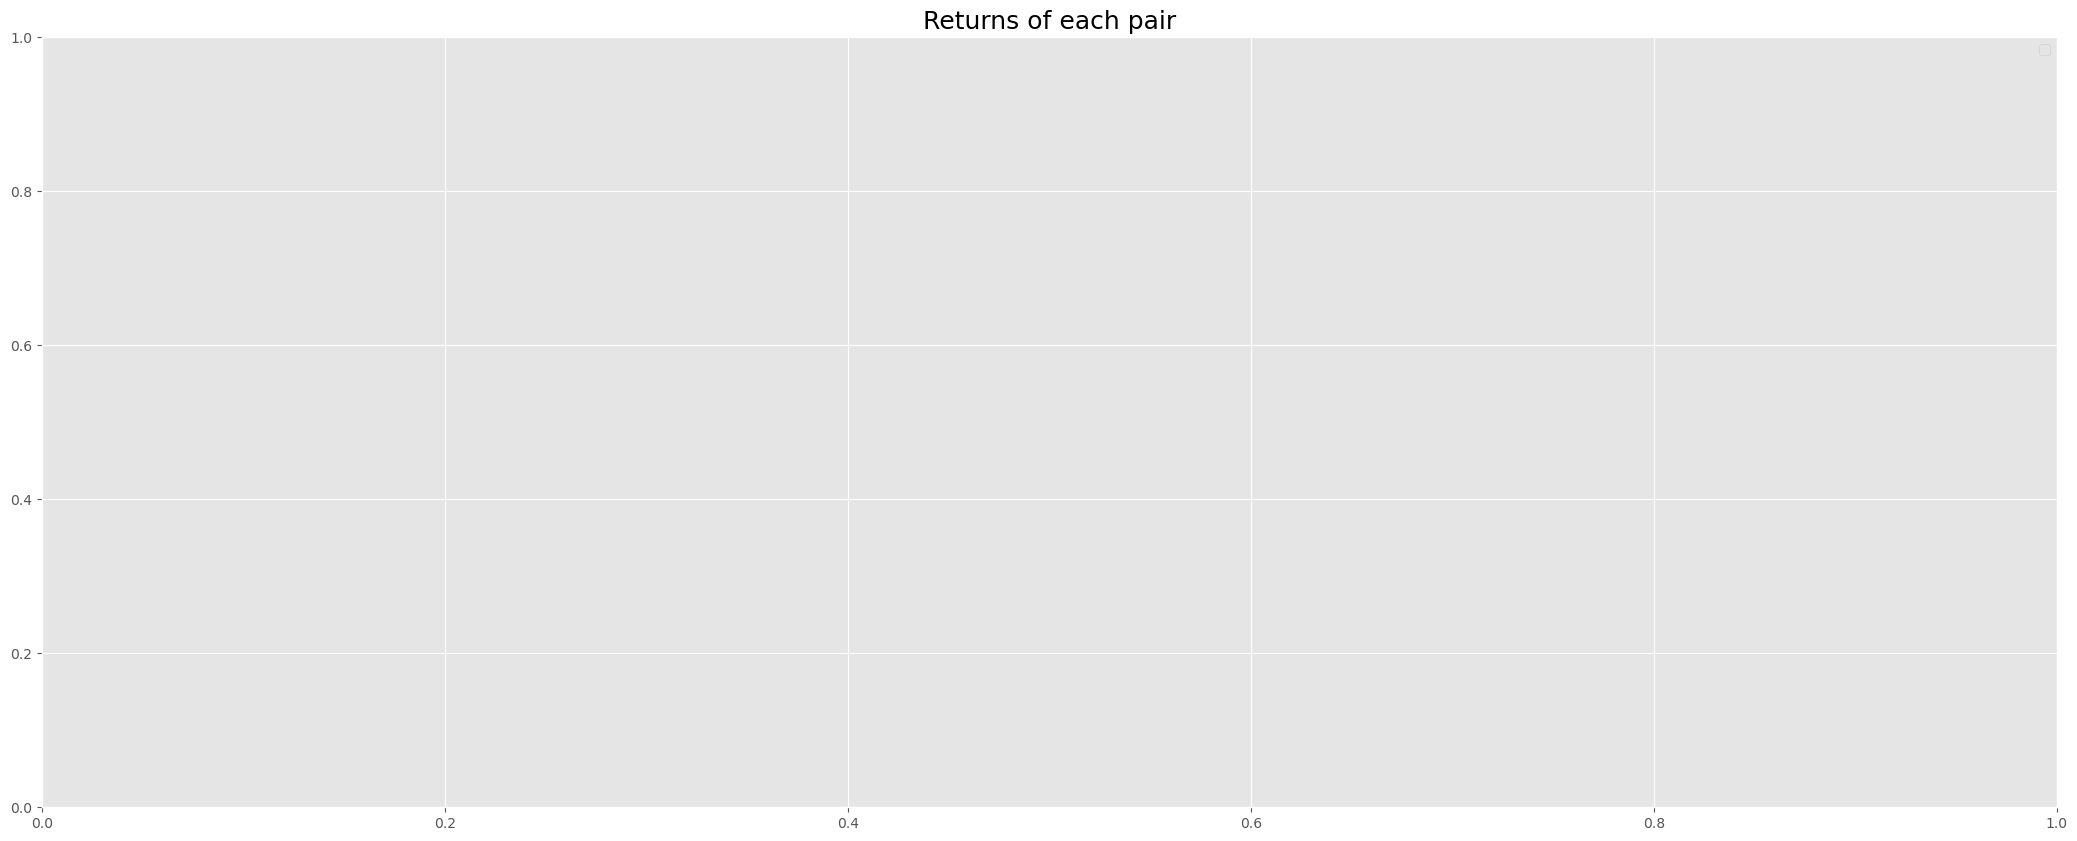

In [16]:
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

plt.figure(figsize = (26, 10))
#for pair in range(len(pairs_list)):
#    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize = 18)

In [17]:

#Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df[0]), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
#print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
#print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
#print('Max profitable trade:', round(max(str_profits), 2))
#print('Max lossing trade:', round(min(str_losses), 2))

***** STRATEGY PERFORMANCE *****
--------------------------------
CAGR: 46.7 %
Sharpe ratio: -0.01
Maximum drawdown 9.38 % 

Number of trades: 30
Number of profits: 16
Number of losses: 13
Number of breakevens: 1 

Winning percentage 55.17 %
ROI: 4545
--------------------------------


Text(0.5, 1.0, 'return of strategy')

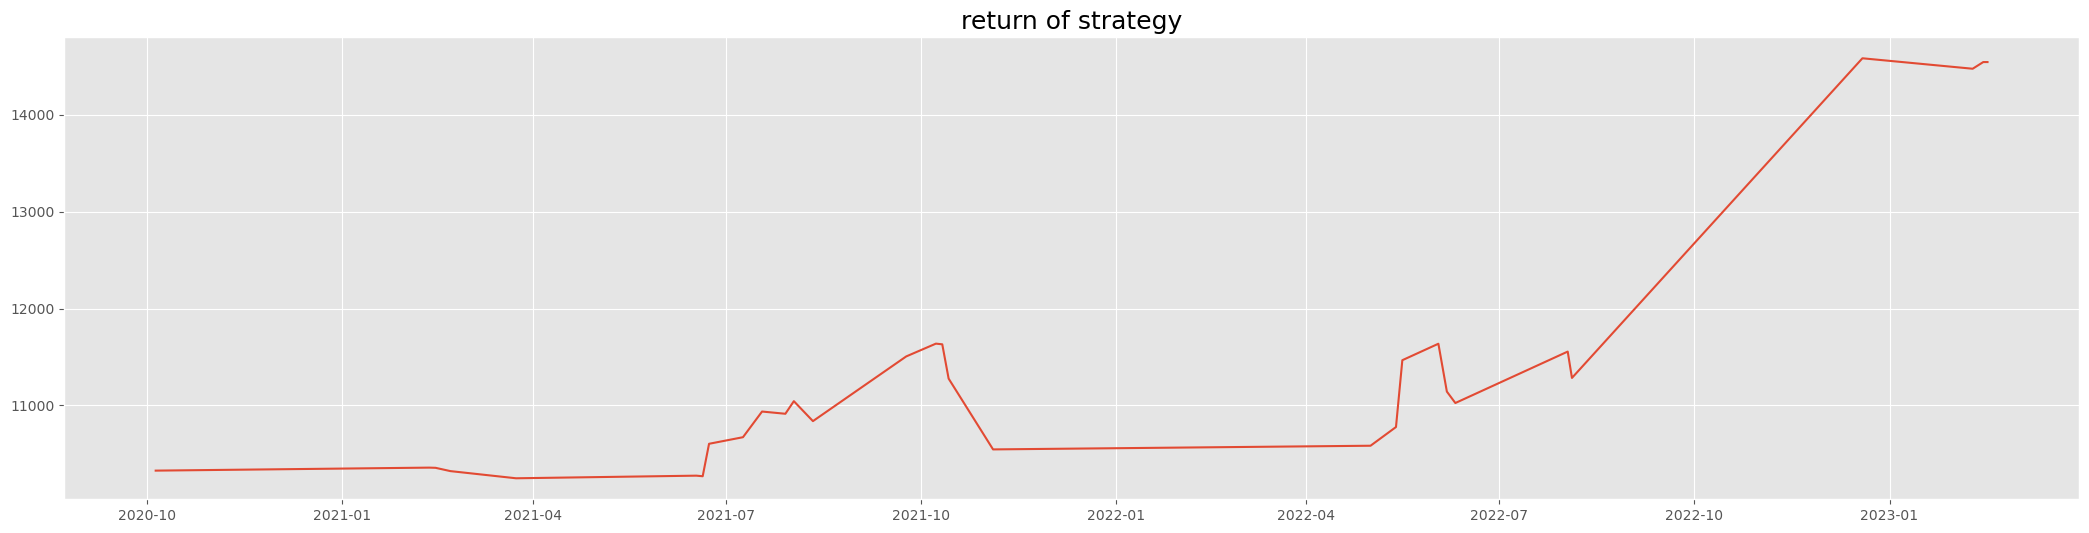

In [18]:

plt.figure(figsize = (26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize = 18)


In [19]:

#performance for each pair
for pair in range(len(pairs_list)):
    print(pairs_list[pair], '- PERFORMANCE')
    print('--------------------------------')
    #print('Number of trades:', len(profits[pair] + losses[pair] + be[pair]))
    #print('Number of profits:', len(profits[pair]))
    #print('Number of losses:', len(losses[pair]))
    #print('Number of breakevens:', len(be[pair]), '\n')
    #print('Winning percentage', (round(len(profits[pair]) / (len(profits[pair]) + len(losses[pair])) * 100, 2)), '%')
    #print('ROI:', round(pairs_results[pair]['cum_res'][-1] - account_size, 2))
    #print('--------------------------------')
    #print('Average profitable trade:', round(sum(profits[pair]) / len(profits[pair]), 2))
    #print('Average lossing trade:', round(sum(losses[pair]) / len(losses[pair]), 2))
    #print('Max profitable trade:', round(max(profits[pair]), 2))
    #print('Max lossing trade:', round(min(losses[pair]), 2))
    #print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx \n')

    trades_per_day = pairs_results[pair].groupby('day_of_trade').count()['result']
    day_return = pairs_results[pair].groupby('day_of_trade').sum()['result']
    day_return_positive = day_return > 0
    positive_results = pairs_results[pair]['result'] > 0

    print('Number of trades per day \n', trades_per_day)

    fig, axes = plt.subplots(4, 1, figsize = (26, 26))
    fig.tight_layout(pad = 4)

    axes[0].plot(pairs_results[pair]['cum_res'], color = 'dodgerblue')
    axes[0].set_title(pairs_list[pair], fontsize = 14)
    axes[0].set_xlabel('Days')
    axes[0].set_ylabel('Return')

    axes[1].bar(day_return.keys(), height = day_return, color = day_return_positive.map({True: 'limegreen', False: 'coral'}))
    axes[1].set_title('Returns per day', fontsize = 14)
    axes[1].set_xlabel('Days')
    axes[1].set_ylabel('Return')

    axes[2].hist(pairs_results[pair]['result'], bins = 500, color = 'purple')
    axes[2].set_title('Distribution of results', fontsize = 14)
    axes[2].set_xlabel('Size of returns')
    axes[2].set_ylabel('Number of returns')

    axes[3].plot(df[pair]['Close'], color = 'black', alpha = 0.5)
    axes[3].scatter(pairs_results[pair].index, pairs_results[pair]['entry_price'], s = 70, color = positive_results.map({True: 'green', False: 'red'}))
    axes[3].set_title('Entries', fontsize = 14)
    axes[3].set_xlabel('Date')
    axes[3].set_ylabel('price')

    plt.show()


naturalgas_1H - PERFORMANCE
--------------------------------


KeyError: 0